In [37]:
import json
from meta import analyze_collection
from pathlib import Path
from nilearn import plotting as niplt
from nilearn import input_data
from nimare.dataset import Dataset
from pyns import Neuroscout
import pandas as pd
import seaborn as sns
import nibabel as nib
from copy import deepcopy
from matplotlib import pyplot as plt
%matplotlib inline

In [86]:
api = Neuroscout()

Exploring single dataset varability of meta-analytic effects

In [2]:
roi_coords = [(27, -53, -9), (42, -52, -24), (-45, -57, -12), (-42, -57, -15)]
labels = [
    'PPA',
    'FFA',
    'vWFA-Chen',
    'vWFA-yarkoni',
    ]

In [3]:
import scipy.stats as sps
from nilearn._utils.glm import z_score
def t_to_z(t_map, dof):
    # Cobbled together from nilearn.glm
    old_shape = t_map.get_data().shape
    data = t_map.get_data().flatten()
    new_img = deepcopy(t_map)
    baseline = 0
    p_value = sps.t.sf(data, dof)
    
    one_minus_pvalues = sps.t.cdf(data, dof)
        
    # Avoid inf values kindly supplied by scipy.
    z_scores = z_score(p_value, one_minus_pvalue=one_minus_pvalues)
    
    z_scores = z_scores.reshape(old_shape)
    
    new_img.get_data()[:] = z_scores
    
    return new_img

In [4]:
def extract_rois(dataset, labels, roi_coords, stat='z', contrast_name=None, radius=8):
    masker = input_data.NiftiSpheresMasker(roi_coords, radius=radius)
    
    if contrast_name is not None:
        dataset = dataset.slice(
           ids=dataset.images.id[dataset.images.contrast_id == contrast_name])
    
    dataset_level_stat = []
    for ix, t_file in enumerate(dataset.images['t']):
        study_id = dataset.images['study_id'].iloc[ix]
        stat_map = nib.load(t_file)
        if stat == 'z':
            dof = dataset.annotations['n_subjects'].iloc[ix] - 1
            stat_map = t_to_z(stat_map, dof)
        roi_values = masker.fit_transform(stat_map)[0]
    
        dataset_level_stat.append(dict(zip(['study_id'] + labels, [study_id] + roi_values.tolist())))
    dataset_level_stat = pd.DataFrame(dataset_level_stat).melt(var_name='ROI', value_name=stat, id_vars=['study_id'])
    
    return dataset_level_stat

#### 1) Building

In [5]:
effect = 'building'

In [71]:
single_pred = json.load((Path('../models') / 'single_predictor.json').open())

In [72]:
building_meta_map = 'ma-maps/building-building.nii.gz'

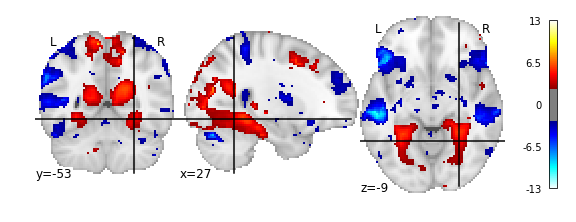

In [73]:
niplt.plot_stat_map(building_meta_map, cut_coords=roi_coords[0], threshold=2.58)

In [74]:
masker = input_data.NiftiSpheresMasker(roi_coords, radius=8)
mean_z = masker.fit_transform(building_meta_map)

In [75]:
print(mean_z)

[[ 3.82821077 -1.47801954 -2.06843912 -0.88275187]]


In [76]:
dataset = Dataset.load('./datasets/building_dset.pkl')

In [87]:
building_dataset_level_z = extract_rois(
    Dataset.load('./datasets/building_dset.pkl'),
    labels,
    roi_coords,
    stat='z',
    radius=8,
    
)

In [23]:
building_dataset = Dataset.load('./datasets/building_dset.pkl')
building_dataset_level_t = extract_rois(
    building_dataset,
    labels,
    roi_coords,
    stat='t',
    radius=8,
    
)

ValueError: Overlap detected between spheres

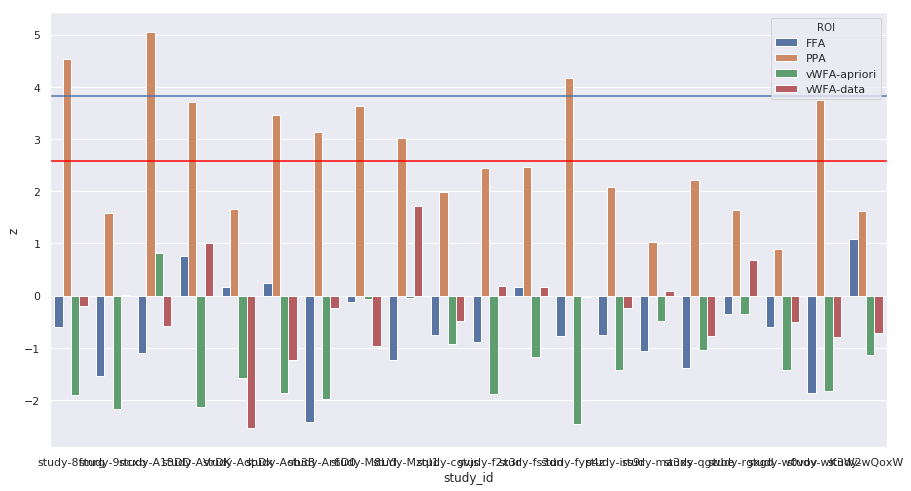

In [101]:
sns.set(rc = {'figure.figsize':(15,8)})
p = sns.barplot(x='study_id', y='z', hue='ROI', data=building_dataset_level_z)
p.axhline(2.58, color='red')
p.axhline(mean_z[0][0])

#### 2) faces

In [107]:
faces_meta_map = 'ma-maps/any_faces+speech+shot_change+log_mean_face_time_cum-anyFaces.nii.gz'
faces_dataset = Dataset.load('./datasets/any_faces+speech+shot_change+log_mean_face_time_cum_dset.pkl')

In [111]:
masker = input_data.NiftiSpheresMasker(roi_coords, radius=8)
faces_mean_z = masker.fit_transform(faces_meta_map)

In [115]:
faces_mean_z[0][1]

2.4539319944472275

In [108]:
faces_dataset_level_z = extract_rois(
    faces_dataset,
    labels,
    roi_coords,
    radius=8,
    contrast_name='anyFaces'
)

INFO:nimare.utils:Shared path detected: '/home/alejandro/repos/neuroscout-paper/meta/images/anyFaces_speech_shotChange_logMeanFaceTimeCum/'


In [125]:
faces_mean_z[0][1]

2.4539319944472275

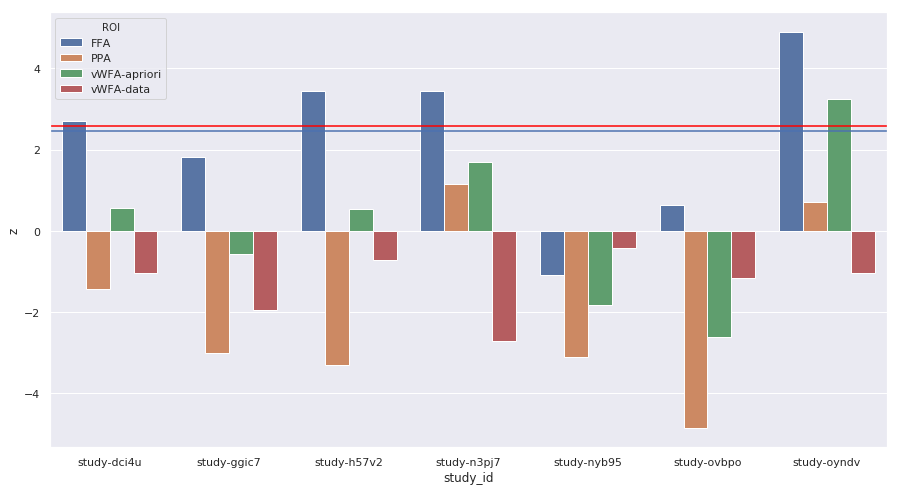

In [116]:
sns.set(rc = {'figure.figsize':(15,8)})
p = sns.barplot(x='study_id', y='z', hue='ROI', data=faces_dataset_level_z)
p.axhline(2.58, color='red')
p.axhline(faces_mean_z[0][1])

3) frequency

In [19]:
freq_meta_map = 'ma-maps/subtlexusfrequency_Lg10WF+speech-subtlexusfrequencyLg10Wf.nii.gz'
frequency_dataset = Dataset.load('./datasets/subtlexusfrequency_Lg10WF+speech_dset.pkl')

In [20]:
masker = input_data.NiftiSpheresMasker(roi_coords, radius=8)
freq_mean_z = masker.fit_transform(freq_meta_map)

In [121]:
frequency_dataset_level_z = extract_rois(
    frequency_dataset,
    labels,
    roi_coords,
    radius=8,
    contrast_name='subtlexusfrequencyLg10Wf'
)

INFO:nimare.utils:Shared path detected: '/home/alejandro/repos/neuroscout-paper/meta/images/subtlexusfrequencyLg10Wf_speech/'


In [22]:
sns.set(rc = {'figure.figsize':(15,8)})
p = sns.barplot(x='study_id', y='z', hue='ROI', data=frequency_dataset_level_z)
p.axhline(-2.58, color='red')
p.axhline(freq_mean_z[0][2])

NameError: name 'frequency_dataset_level_z' is not defined

In [132]:
frequency_dataset_level_z_1 = extract_rois(
    frequency_dataset,
    labels,
    roi_coords,
    radius=1,
    contrast_name='subtlexusfrequencyLg10Wf'
)

INFO:nimare.utils:Shared path detected: '/home/alejandro/repos/neuroscout-paper/meta/images/subtlexusfrequencyLg10Wf_speech/'


In [142]:
sns.set(rc = {'figure.figsize':(15,8)})
p = sns.barplot(x='study_id', y='z', hue='ROI', data=frequency_dataset_level_t_1)
p.axhline(-2.58)

NameError: name 'frequency_dataset_level_t_1' is not defined

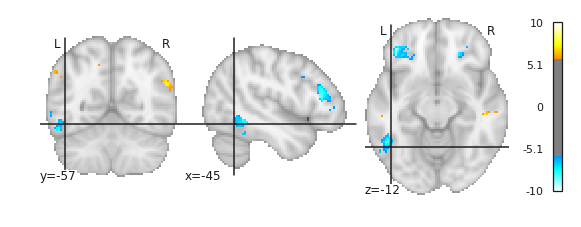

In [131]:
niplt.plot_stat_map(freq_meta_map, cut_coords=roi_coords[2], threshold=6)

In [141]:
#Also add axial slices of dataset level estimates plucked from map

### Concreteness + frequency on vWFA only

In [6]:
freq_meta_map = 'ma-maps/subtlexusfrequency_Lg10WF+speech+massiveauditorylexicaldecision_PhonLev+text_length+massiveauditorylexicaldecision_NumSylls+massiveauditorylexicaldecision_NumPhones+massiveauditorylexicaldecision_Dura-subtlexusfrequencyLg10Wf.nii.gz'
concreteness_meta_map = 'ma-maps/subtlexusfrequency_Lg10WF+speech+massiveauditorylexicaldecision_PhonLev+text_length+massiveauditorylexicaldecision_NumSylls+massiveauditorylexicaldecision_NumPhones+massiveauditorylexicaldecision_Dura-concretenessConc.M.nii.gz'
lexical_dataset = Dataset.load('./datasets/subtlexusfrequency_Lg10WF+speech+massiveauditorylexicaldecision_PhonLev+text_length+massiveauditorylexicaldecision_NumSylls+massiveauditorylexicaldecision_NumPhones+massiveauditorylexicaldecision_Duration+concreteness_Conc.M_dset.pkl')

In [7]:
frequency_all_lexical_dataset_level_z = extract_rois(
    lexical_dataset,
    [labels[2]],
    [roi_coords[2]],
    radius=6,
    contrast_name='subtlexusfrequencyLg10Wf'
)

INFO:nimare.utils:Shared path detected: '/home/alejandro/repos/neuroscout-paper/meta/images/subtlexusfrequencyLg10Wf_speech_massiveauditorylexicaldecisionPhonlev_textLength_massiveauditorylexicaldecisionNumsylls_massiveauditorylexicaldecisionNumphones_massiveauditorylexicaldecisionDuration_concretenessConc.M/'


In [249]:
lexical_dataset,

Dataset(264 experiments, space='mni152_2mm')

In [8]:
concreteness_all_lexical_dataset_level_z = extract_rois(
    lexical_dataset,
    [labels[2]],
    [roi_coords[2]],
    radius=6,
    contrast_name='concretenessConc.M'
)

INFO:nimare.utils:Shared path detected: '/home/alejandro/repos/neuroscout-paper/meta/images/subtlexusfrequencyLg10Wf_speech_massiveauditorylexicaldecisionPhonlev_textLength_massiveauditorylexicaldecisionNumsylls_massiveauditorylexicaldecisionNumphones_massiveauditorylexicaldecisionDuration_concretenessConc.M/'


In [248]:
roi_coords[2]

(-45, -57, -12)

In [9]:
concreteness_all_lexical_dataset_level_z['contrast'] = 'concretenessConc.M'
frequency_all_lexical_dataset_level_z['contrast'] = 'subtlexusfrequencyLg10Wf'

In [50]:
concat = pd.concat([concreteness_all_lexical_dataset_level_z, frequency_all_lexical_dataset_level_z])
concat['z_abs'] = concat['z'].abs()

In [51]:
#  Ratio between two z values
ratio = concat.groupby('study_id').apply(lambda x: (x.iloc[0]['z_abs'] / x.iloc[1]['z_abs']))
ratio.name = 'ratio'
ratio = ratio.to_frame().reset_index()
concat = concat.merge(ratio)

In [52]:
anns = lexical_dataset.annotations[lexical_dataset.annotations.contrast_id=='concretenessConc.M']
anns = anns[['study_id', 'dataset', 'task']]
anns['dataset-task'] = anns.apply(lambda x: f"{x['dataset']}-{x['task']}", axis=1)

In [55]:
concat = concat.merge(anns)

In [84]:
concat = concat.sort_values('ratio')

In [89]:
tasks = api.tasks.get()

In [92]:
for t in tasks:
    t['dataset_name'] = api.datasets.get(t['dataset_id'])['name']

In [96]:
n_subjects = pd.DataFrame(
    [{'dataset-task': f"{t['dataset_name']}-{t['name']}", 'n_subjects': t['n_subjects']} for t in tasks])

In [99]:
concat = pd.merge(n_subjects, concat)

In [102]:
concat = concat.sort_values('n_subjects')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 <a list of 32 Text xticklabel objects>)

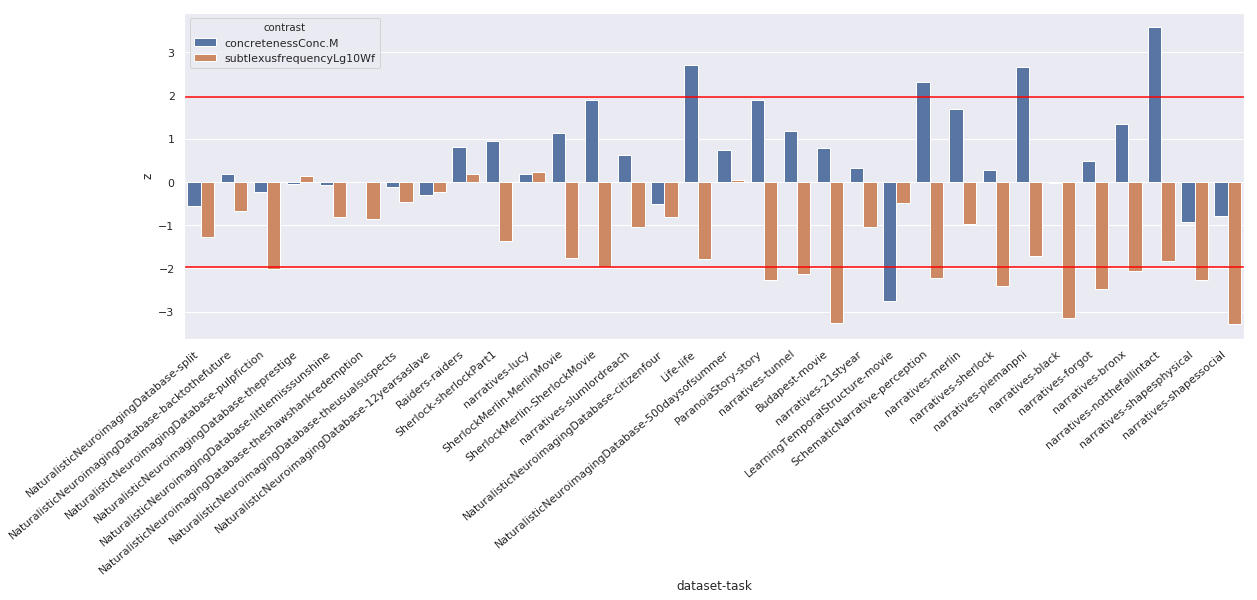

In [123]:
sns.set(rc = {'figure.figsize':(19,6)})
p = sns.barplot(x='dataset-task', y='z', hue='contrast', data=concat)
p.axhline(1.959964, color='red')
p.axhline(-1.959964, color='red')
plt.xticks(rotation = 40, ha='right')

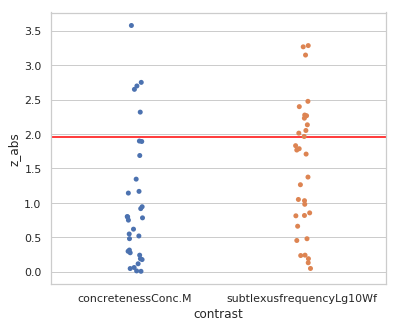

In [141]:
sns.set(rc = {'figure.figsize':(6,5)})
sns.set(style="whitegrid")
p = sns.stripplot(y=concat['z_abs'], x=concat['contrast'], jitter=0.05)
p.axhline(1.959964, color='red')

In [117]:
concat = concat[concat.dataset != 'HealthyBrainNetwork']

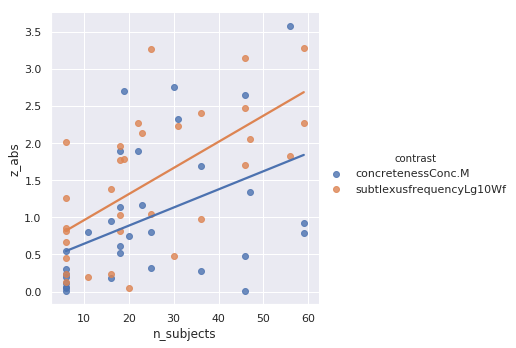

In [122]:
sns.lmplot(data=concat, x="n_subjects", y="z_abs", hue='contrast', ci=None)

In [119]:
pd.merge(concreteness_all_lexical_dataset_level_z, frequency_all_lexical_dataset_level_z)

,study_id,ROI,z,contrast,z_concreteness,z_frequency


In [120]:
merged = pd.merge(pd.merge(frequency_all_lexical_dataset_level_z, anns), pd.merge(concreteness_all_lexical_dataset_level_z, anns), on='dataset-task')

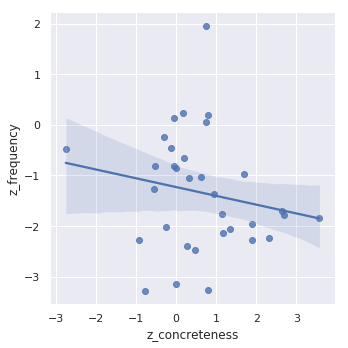

In [121]:
sns.lmplot(data=merged, x="z_concreteness", y="z_frequency")

In [258]:
paired = pd.DataFrame()
paired['Frequency'] = merged['z_frequency'] * -1
paired['Concreteness'] = merged['z_concreteness']

Text(0,0.5,'Z stat (abs)')

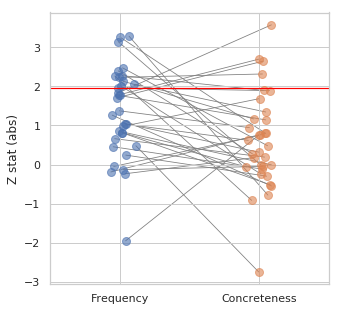

In [259]:
sns.set(rc = {'figure.figsize':(5,5)})
sns.set(style="whitegrid")

jitter = 0.05
df_x_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=paired.values.shape), columns=paired.columns)
df_x_jitter += np.arange(len(paired.columns))

fig, ax = plt.subplots()
for col in paired:
    ax.plot(df_x_jitter[col], paired[col], 'o', alpha=.60, zorder=1, ms=8, mew=1)
ax.set_xticks(range(len(paired.columns)))
ax.set_xticklabels(paired.columns)
ax.set_xlim(-0.5,len(paired.columns)-0.5)

for idx in paired.index:
    ax.plot(df_x_jitter.loc[idx,['Concreteness','Frequency']], paired.loc[idx,['Concreteness','Frequency']], color = 'grey', linewidth = 0.8, linestyle = '-', zorder=-1)
ax.axhline(1.959964, color='red', linewidth = 1.2)
ax.set_ylabel('Z stat (abs)')

In [257]:
((merged.z_frequency.abs() < 1.959964) & (merged.z_concreteness.abs() < 1.959964)).sum()

17

In [29]:
at_least_05 = concat.groupby('study_id').apply(lambda x: (x['z_abs']).sum())

In [30]:
at_least_05 = concat[concat.study_id.isin(at_least_05[at_least_05 >= 1.96].index)]

In [31]:
at_least_05 = at_least_05.merge(ratio)

In [ ]:
at_least_05

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

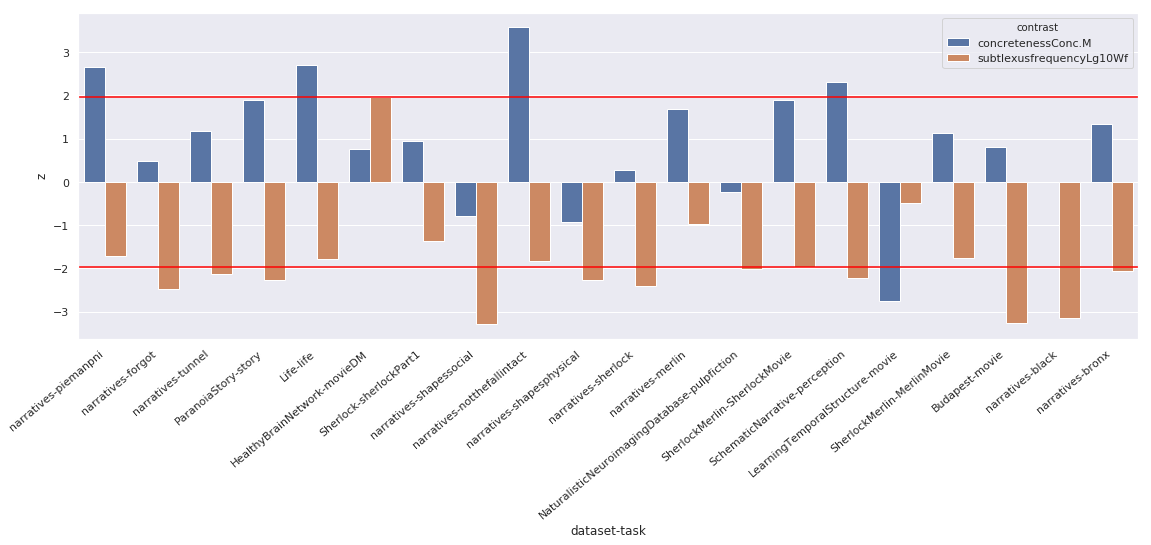

In [38]:
sns.set(rc = {'figure.figsize':(19,6)})
p = sns.barplot(x='dataset-task', y='z', hue='contrast', data=at_least_05)
p.axhline(1.96, color='red')
p.axhline(-1.96, color='red')
plt.xticks(rotation = 40, ha='right')

In [ ]:
lexical_dataset.

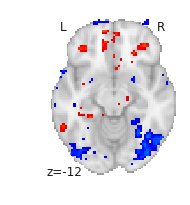

In [192]:
api.analyses.get_analysis(at_least_05.iloc[0].study_id.split('-')[1]).plot_uploads(
    image_filters={'level':'GROUP', 'basename': 'task-black_space-MNI152NLin2009cAsym_contrast-concretenessConc.M_stat-t_statmap.nii.gz'},
    plot_args={'threshold':1.959964, 'cut_coords': [-12], 'display_mode': 'z', 'vmax': 6.4, 'colorbar': False})

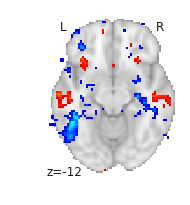

In [193]:
api.analyses.get_analysis(at_least_05.iloc[0].study_id.split('-')[1]).plot_uploads(
    image_filters={'level':'GROUP', 'basename': 'task-black_space-MNI152NLin2009cAsym_contrast-subtlexusfrequencyLg10Wf_stat-t_statmap.nii.gz'},
    plot_args={'threshold':1.959964, 'cut_coords': [-12], 'display_mode': 'z', 'vmax': 6.4, 'colorbar': False})

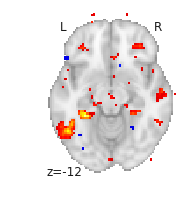

In [195]:
api.analyses.get_analysis(at_least_05.iloc[-8].study_id.split('-')[1]).plot_uploads(
    image_filters={'level':'GROUP', 'basename': 'task-piemanpni_space-MNI152NLin2009cAsym_contrast-concretenessConc.M_stat-t_statmap.nii.gz'},
    plot_args={'threshold':1.959964, 'cut_coords': [-12], 'display_mode': 'z', 'vmax': 6.4, 'colorbar': False})

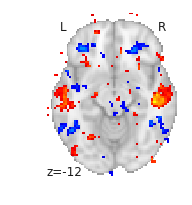

In [196]:
api.analyses.get_analysis(at_least_05.iloc[-8].study_id.split('-')[1]).plot_uploads(
    image_filters={'level':'GROUP', 'basename': 'task-piemanpni_space-MNI152NLin2009cAsym_contrast-subtlexusfrequencyLg10Wf_stat-t_statmap.nii.gz'},
    plot_args={'threshold':1.959964, 'cut_coords': [-12], 'display_mode': 'z', 'vmax': 6.4, 'colorbar': False})

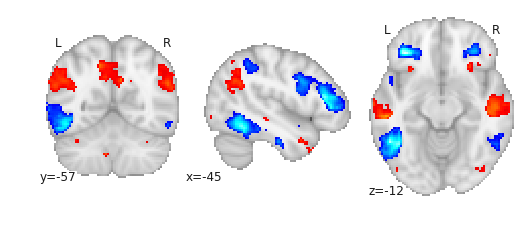

In [206]:
niplt.plot_stat_map(freq_meta_map, cut_coords=roi_coords[2], draw_cross=False, threshold=3.290527, vmax=10, colorbar=False)

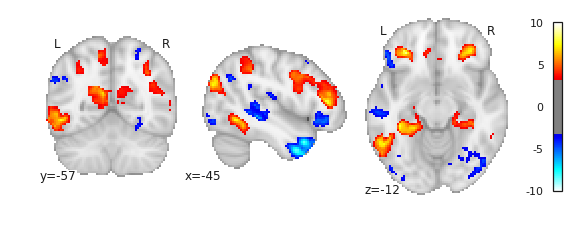

In [207]:
niplt.plot_stat_map(concreteness_meta_map, cut_coords=roi_coords[2],  draw_cross=False, threshold=3.290527, vmax=10)